In [1]:
suppressPackageStartupMessages({
    library(scater)
    library(scran)
    library(SingleCellExperiment)
    library(tidyverse)
    library(reticulate)
    library(BiocParallel)
    library(logger)
    library(showtext)
    library(batchelor)
    library(patchwork)
})
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 300)

In [71]:
log_info("Reading SCE object...")
sce_complete <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered.rds")
log_info("SCE object done")


In [72]:
sce <- sce_complete[, sce_complete$leiden_global_celltype %in% c("T Cell", "Proliferative T/NK", 
                                                                 "Tissue Resident CD16+ NK", "Blood CD16+ NK",
                                                                 "CD16- NK")]
sce <- logNormCounts(sce)

In [73]:
table(sce$leiden_global_celltype)


          Blood CD16+ NK                 CD16- NK       Proliferative T/NK 
                     507                      309                       82 
                  T Cell Tissue Resident CD16+ NK 
                    1774                      315 

# Feature Selection

In [74]:
keep <- rowData(sce)$Biotype == "protein_coding"
dec <- modelGeneVar(sce, subset.row = keep, min.mean = 1, density.weights=TRUE)
hvgs <- getTopHVGs(dec, n = 3000)

# Clustering by scanpy

In [75]:
adata_sce <- zellkonverter::SCE2AnnData(sce, X_name = "logcounts")
sc <- import("scanpy")
adata_sce$var['highly_variable'] <- rownames(adata_sce$var) %in% hvgs
log_info("Run PCA")
sc$tl$pca(adata_sce, use_highly_variable=TRUE)

In [76]:
mt_pca <- adata_sce$obsm['X_pca']

In [77]:
mnn_out <- reducedMNN(mt_pca, batch = sce$donor, auto.merge = TRUE, k=10, BPPARAM = MulticoreParam(workers = 12))

Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped at the number of observations”
Warning message in .refine_k(k, precomputed, query = TRUE):
“'k' capped a

In [78]:
adata_sce$obsm$update(X_mnn = mnn_out$corrected)
sc$pp$neighbors(adata_sce, n_pcs = 50L, use_rep = "X_mnn" )
log_info("Run UMAP")
sc$tl$umap(adata_sce)
sc$tl$leiden(adata_sce, resolution = 1)
log_info("Convert back to sce")
sce <- zellkonverter::AnnData2SCE(adata_sce)

Note: Using stored X_name value 'logcounts'



In [79]:
reducedDim(sce, "PCA") <- reducedDim(sce, "X_pca")
reducedDim(sce, "UMAP") <- reducedDim(sce, "X_umap")


In [80]:
sce_old <- readRDS("../../../data/expression/sce/archive/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds")
ov_cells <- intersect(colnames(sce_old), colnames(sce))
colData(sce)[ov_cells, "old_anno"] <- as.character(colData(sce_old)[ov_cells, "celltype"])

In [97]:
keep <- rowData(sce)$Biotype == 'protein_coding'
markers <- findMarkers(sce, groups = sce$leiden_anno, lfc = 1, direction = 'up', subset.row = keep)
top_markers <- lapply(markers, function(df) {
    df <- cbind(gene = rownames(df), as.data.frame(df))
    df[which(df$Top <= 30),]
})

In [94]:
leiden2celltype <- c(
    '0' = 'CD8_C03-GZMK',
    '1' = 'CD4/CD8_C01-LEF1',
    '2' = 'CD4_C06-IL7R',
    '3' = 'NK_C01-FCGR3A',
    '4' = 'NK_C02-CD160',
    '5' = 'NK_C03-IFNG',
    '6' = 'CD8_C05-CX3CR1',
    '7' = 'CD8_C04-SLC4A10',
    '8' = 'CD4/CD8_C02-MKI67',
    '9' = 'CD4_C07-FOXP3',
    '10' = 'NK_C04-SELL',
    '11' = 'NK_C05-MKI67'
)
sce$leiden_anno <- plyr::mapvalues(x = sce$leiden, from = names(leiden2celltype), to = leiden2celltype)

In [96]:
table(sce$leiden_anno)


     CD8_C03-GZMK  CD4/CD8_C01-LEF1      CD4_C06-IL7R     NK_C01-FCGR3A 
              512               412               388               346 
     NK_C02-CD160       NK_C03-IFNG    CD8_C05-CX3CR1   CD8_C04-SLC4A10 
              304               296               244               186 
CD4/CD8_C02-MKI67     CD4_C07-FOXP3       NK_C04-SELL      NK_C05-MKI67 
              115               106                51                27 

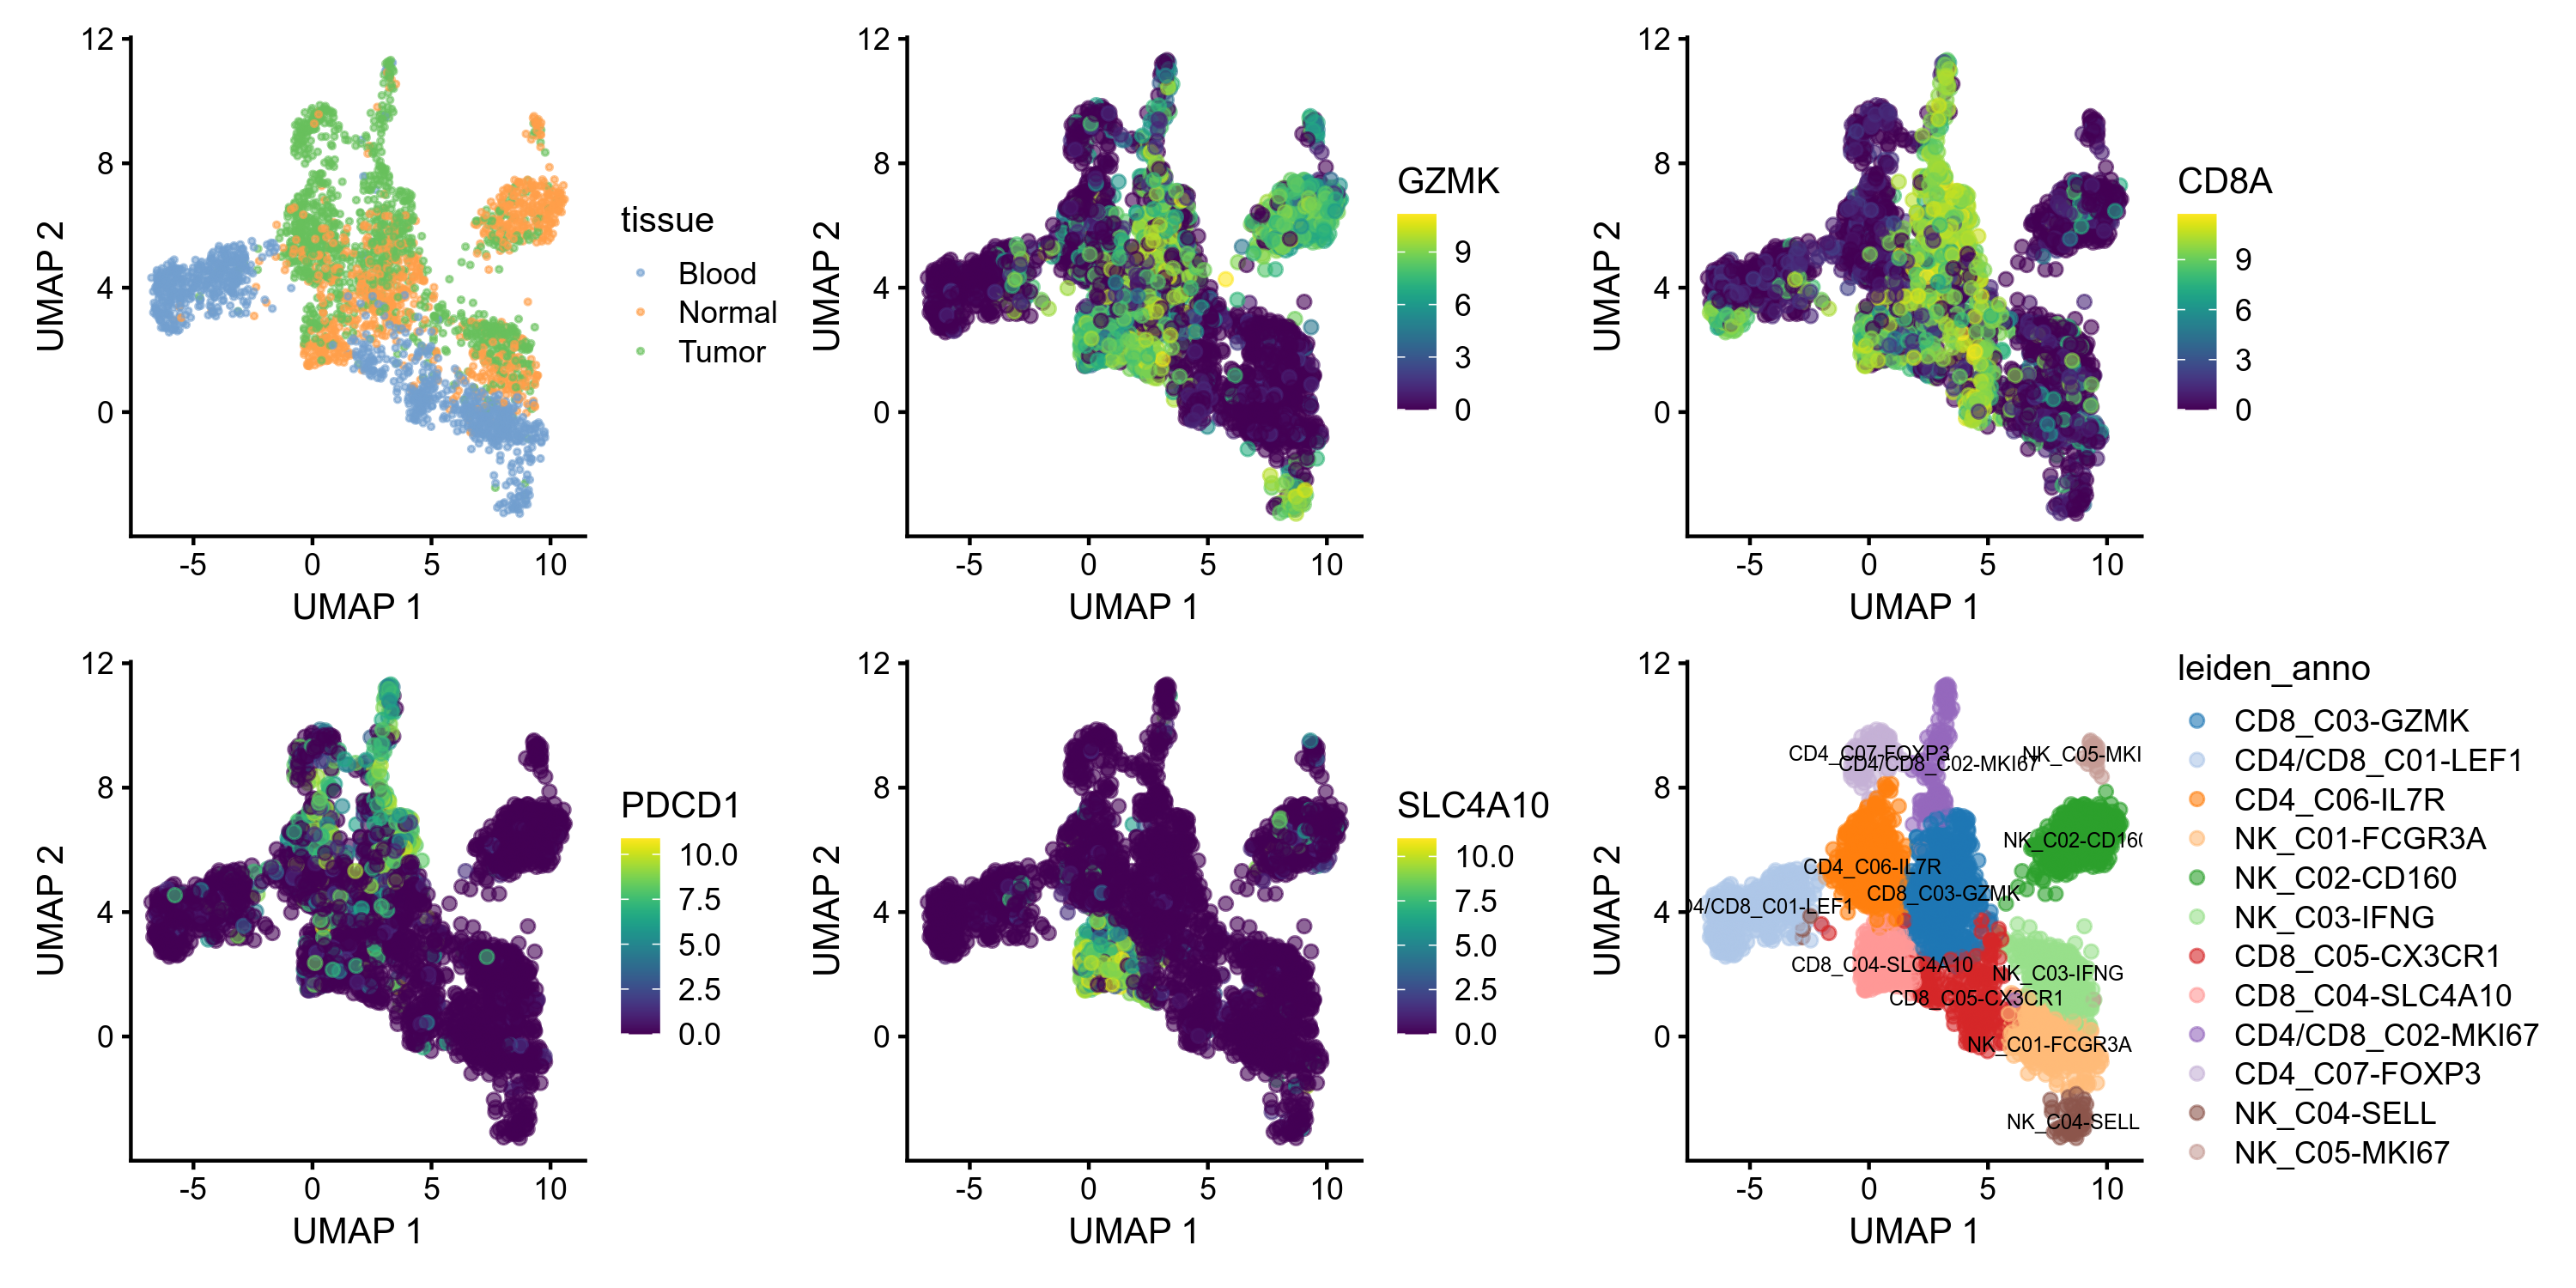

In [95]:
options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 300)
p1 <- plotUMAP(sce, colour_by = 'tissue', point_size = .5)
p2 <- plotUMAP(sce, colour_by = 'GZMK')
p3 <- plotUMAP(sce, colour_by = 'CD8A')
p4 <- plotUMAP(sce, colour_by = 'PDCD1')
p5 <- plotUMAP(sce, colour_by = 'SLC4A10')
p6 <- plotUMAP(sce, colour_by = 'leiden_anno', text_by = 'leiden_anno', text_size = 2)


p1 + p2 + p3 + p4 + p5 + p6

In [98]:
saveRDS(sce, file = "../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_T_NK.rds")

In [2]:
sce <- readRDS("../../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_T_NK.rds")

In [11]:
?ggpubr::theme_pubr()

theme_pubr               package:ggpubr                R Documentation

_P_u_b_l_i_c_a_t_i_o_n _r_e_a_d_y _t_h_e_m_e

_D_e_s_c_r_i_p_t_i_o_n:

        • *theme_pubr()*: Create a publication ready theme

        • *theme_pubclean()*: a clean theme without axis lines, to
          direct more attention to the data.

        • *labs_pubr()*: Format only plot labels to a publication ready
          style

        • *theme_classic2()*: Create a classic theme with axis lines.

        • *clean_theme()*: Remove axis lines, ticks, texts and titles.

        • *clean_table_theme()*: Clean the the theme of a table, such
          as those created by ‘ggsummarytable()’

     .

_U_s_a_g_e:

     theme_pubr(
       base_size = 12,
       base_family = "",
       border = FALSE,
       margin = TRUE,
       legend = c("top", "bottom", "left", "right", "none"),
       x.text.angle = 0
     )
     
     theme_pubclean(base_size = 12, base_family = "", flip = FALSE)
     
     labs_pubr(base_size = 14, base_family = "")
     
     theme_classic2(base_size = 12, base_family = "")
     
     clean_theme()
     
     clean_table_theme()
     
_A_r_g_u_m_e_n_t_s:

base_size: base font size

base_family: base font family

  border: logical value. Default is FALSE. If TRUE, add panel border.

  margin: logical value. Default is TRUE. If FALSE, reduce plot margin.

  legend: character specifying legend position. Allowed values are one
          of c("top", "bottom", "left", "right", "none"). Default is
          "top" side position. to remove the legend use legend =
          "none". Legend position can be also specified using a numeric
          vector c(x, y).  In this case it is possible to position the
          legend inside the plotting area. x and y are the coordinates
          of the legend box. Their values should be between 0 and 1.
          c(0,0) corresponds to the "bottom left" and c(1,1)
          corresponds to the "top right" position. For instance use
          legend = c(0.8, 0.2).

x.text.angle: Rotation angle of x axis tick labels. Default value is 0.
          Use 90 for vertical text.

    flip: logical. If TRUE, grid lines are added to y axis instead of x
          axis.

_E_x_a_m_p_l_e_s:

     p <- ggplot(mtcars, aes(x = wt, y = mpg)) +
        geom_point(aes(color = gear))
     
     # Default plot
     p
     
     # Use theme_pubr()
     p + theme_pubr()
     
     # Format labels
     p + labs_pubr()

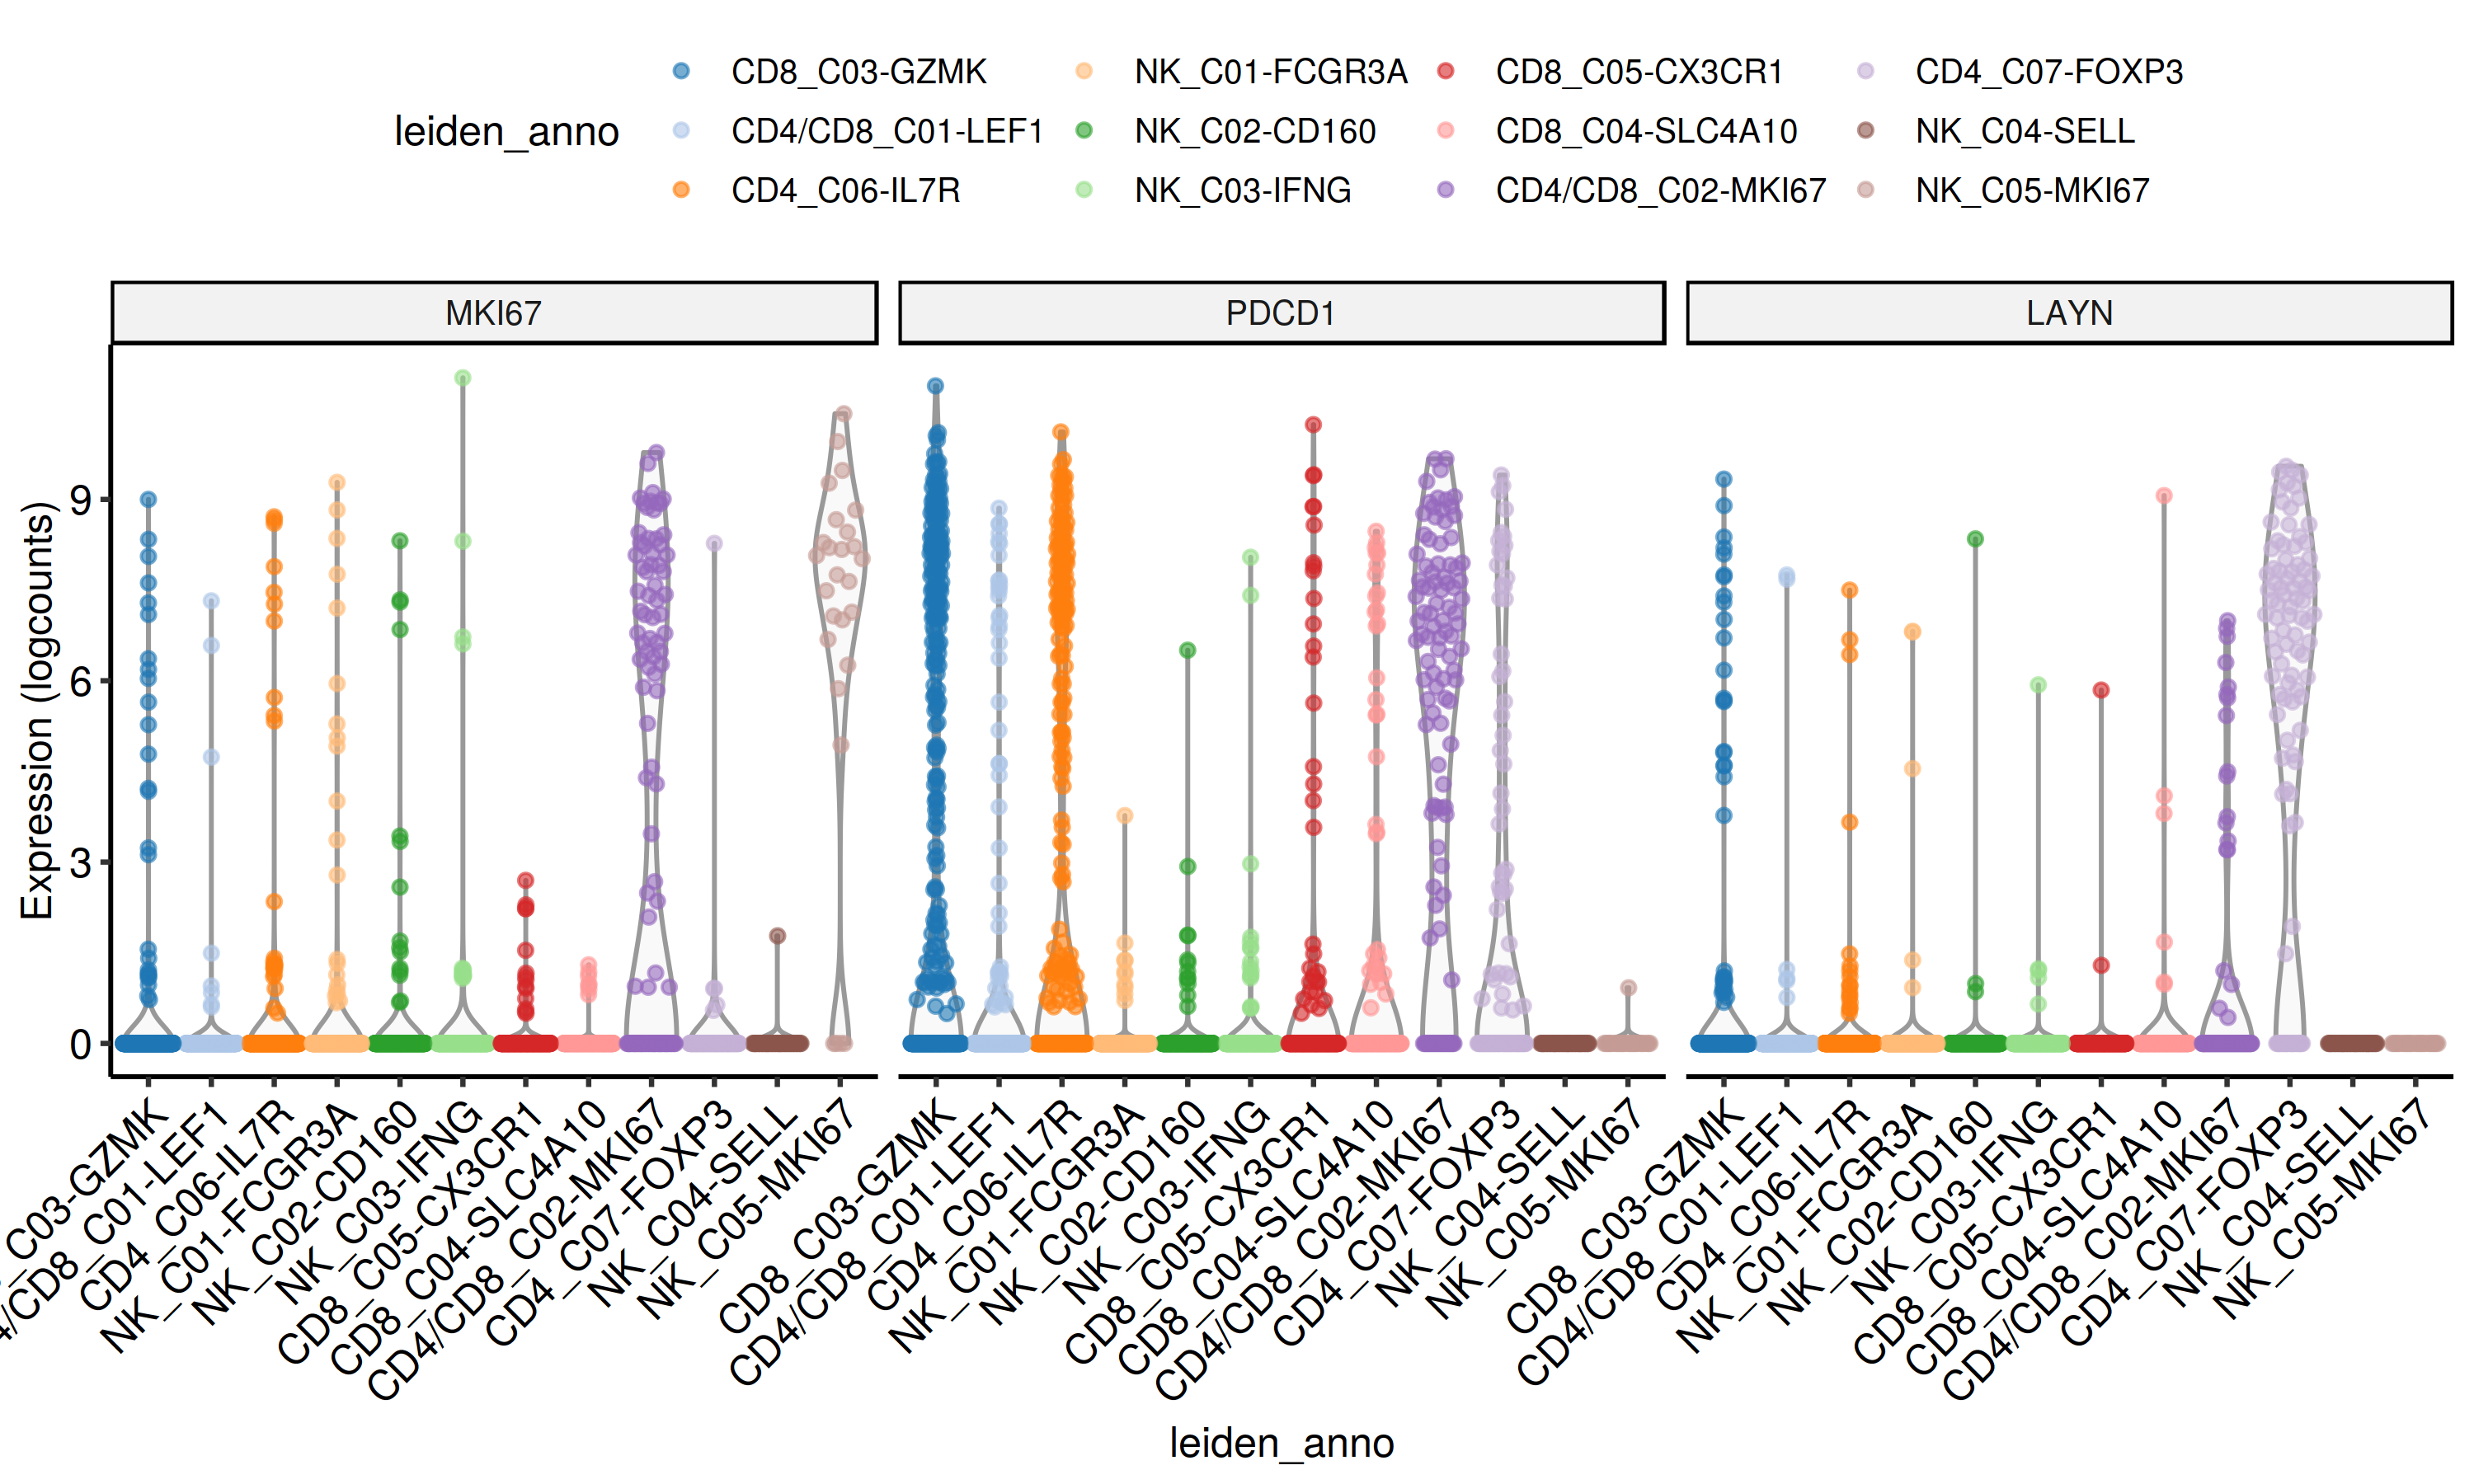

In [13]:
options(repr.plot.height = 6)
plotExpression(sce, x = "leiden_anno", features = c("MKI67", "PDCD1", "LAYN"), ncol = 3, colour_by = 'leiden_anno') +
    ggpubr::theme_pubr( x.text.angle = 45)

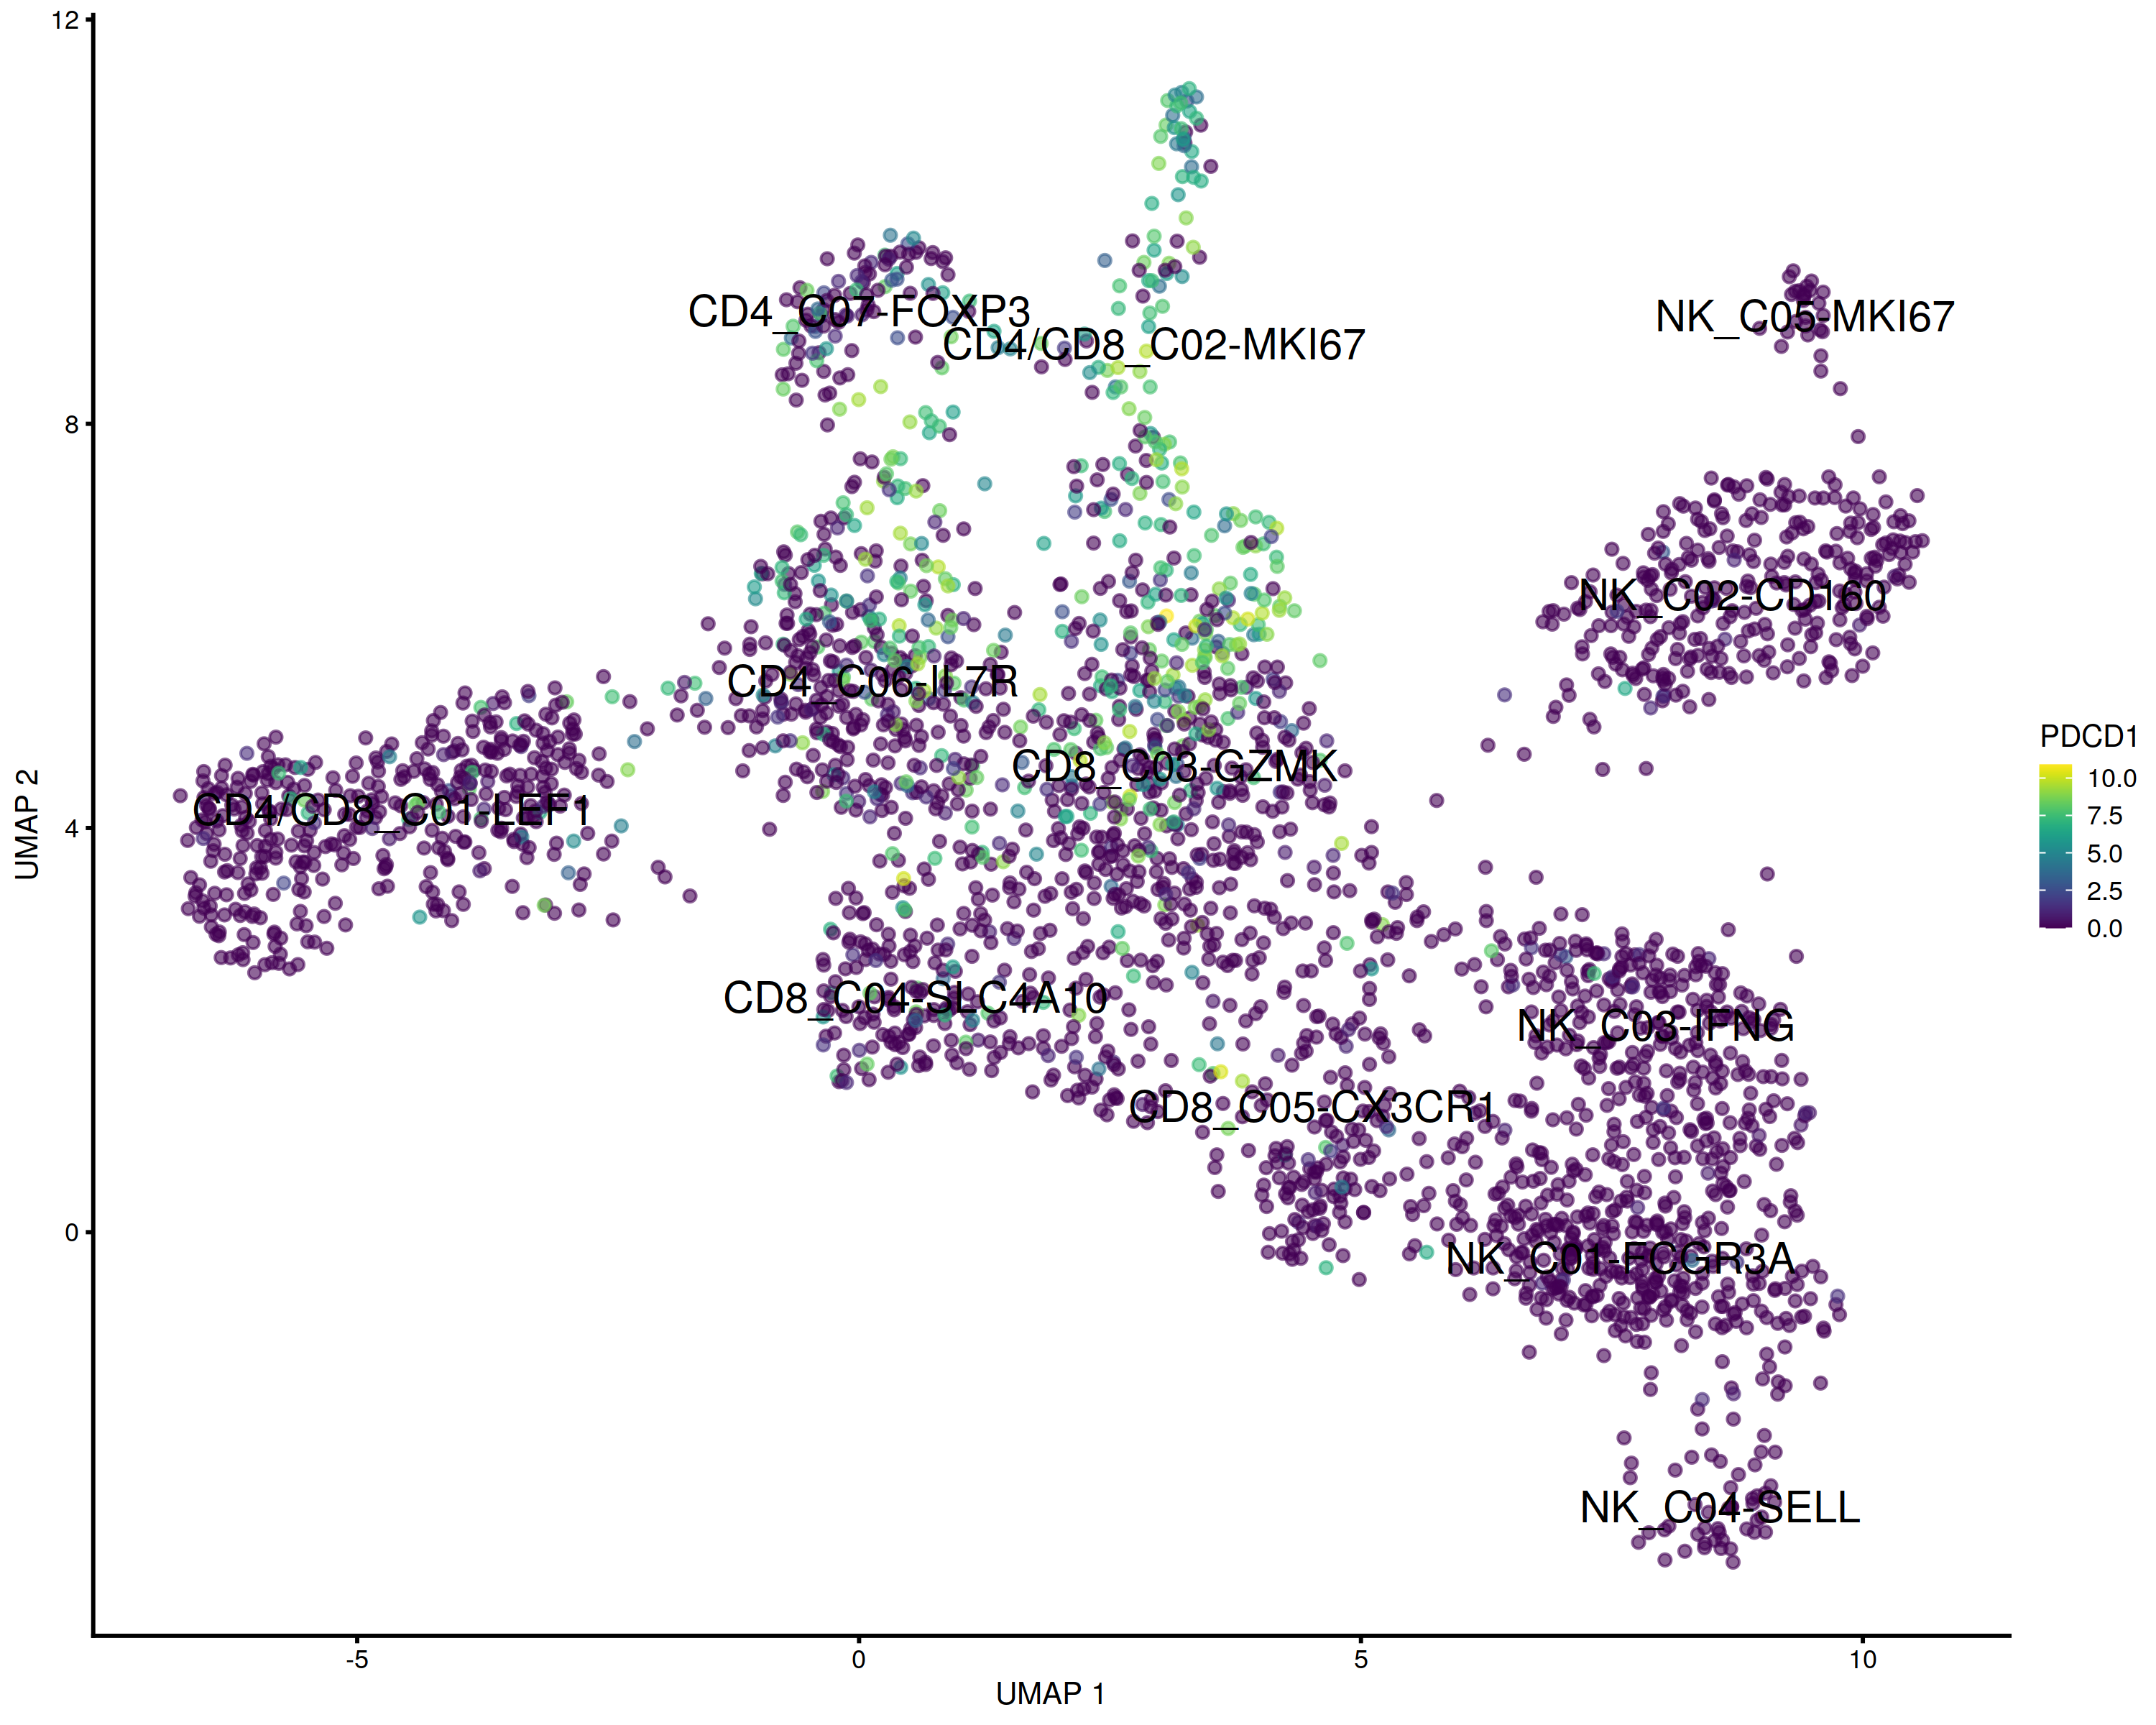

In [6]:
plotUMAP(sce, colour_by = "PDCD1", text_by = "leiden_anno")

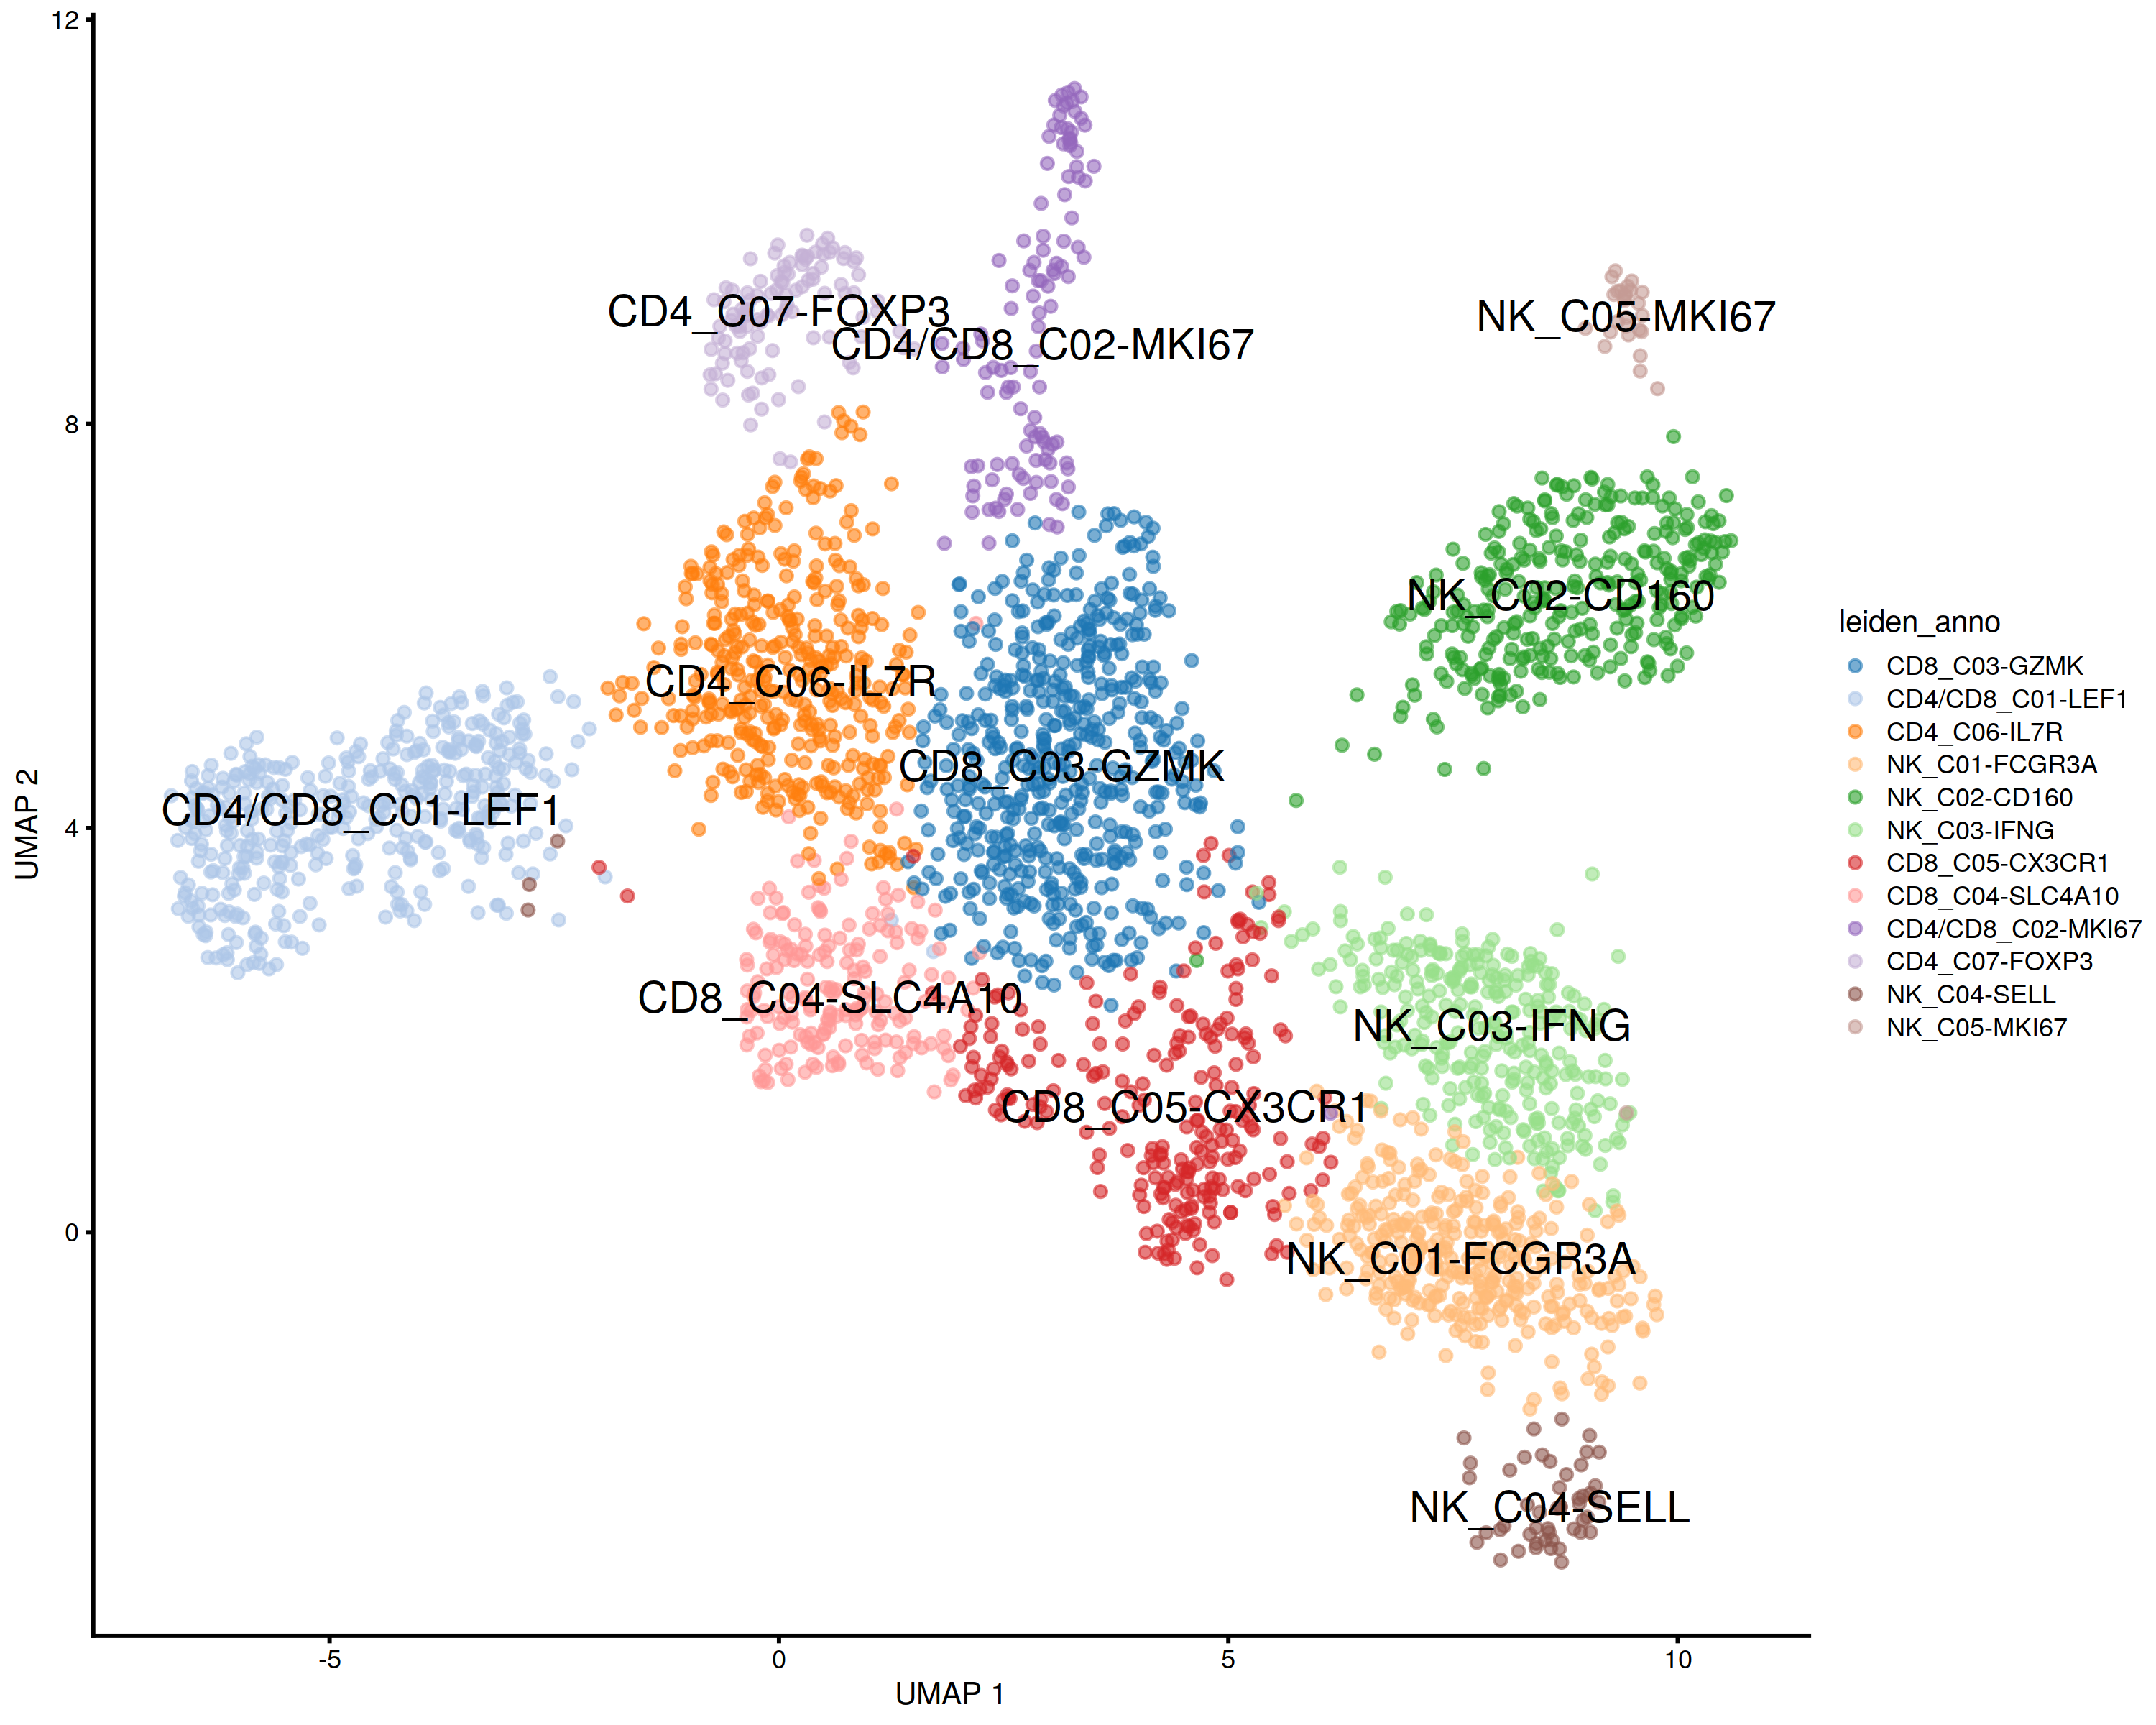

In [4]:
plotUMAP(sce, colour_by = "leiden_anno", text_by = "leiden_anno")

Warning message:
“Removed 51 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_label_repel).”


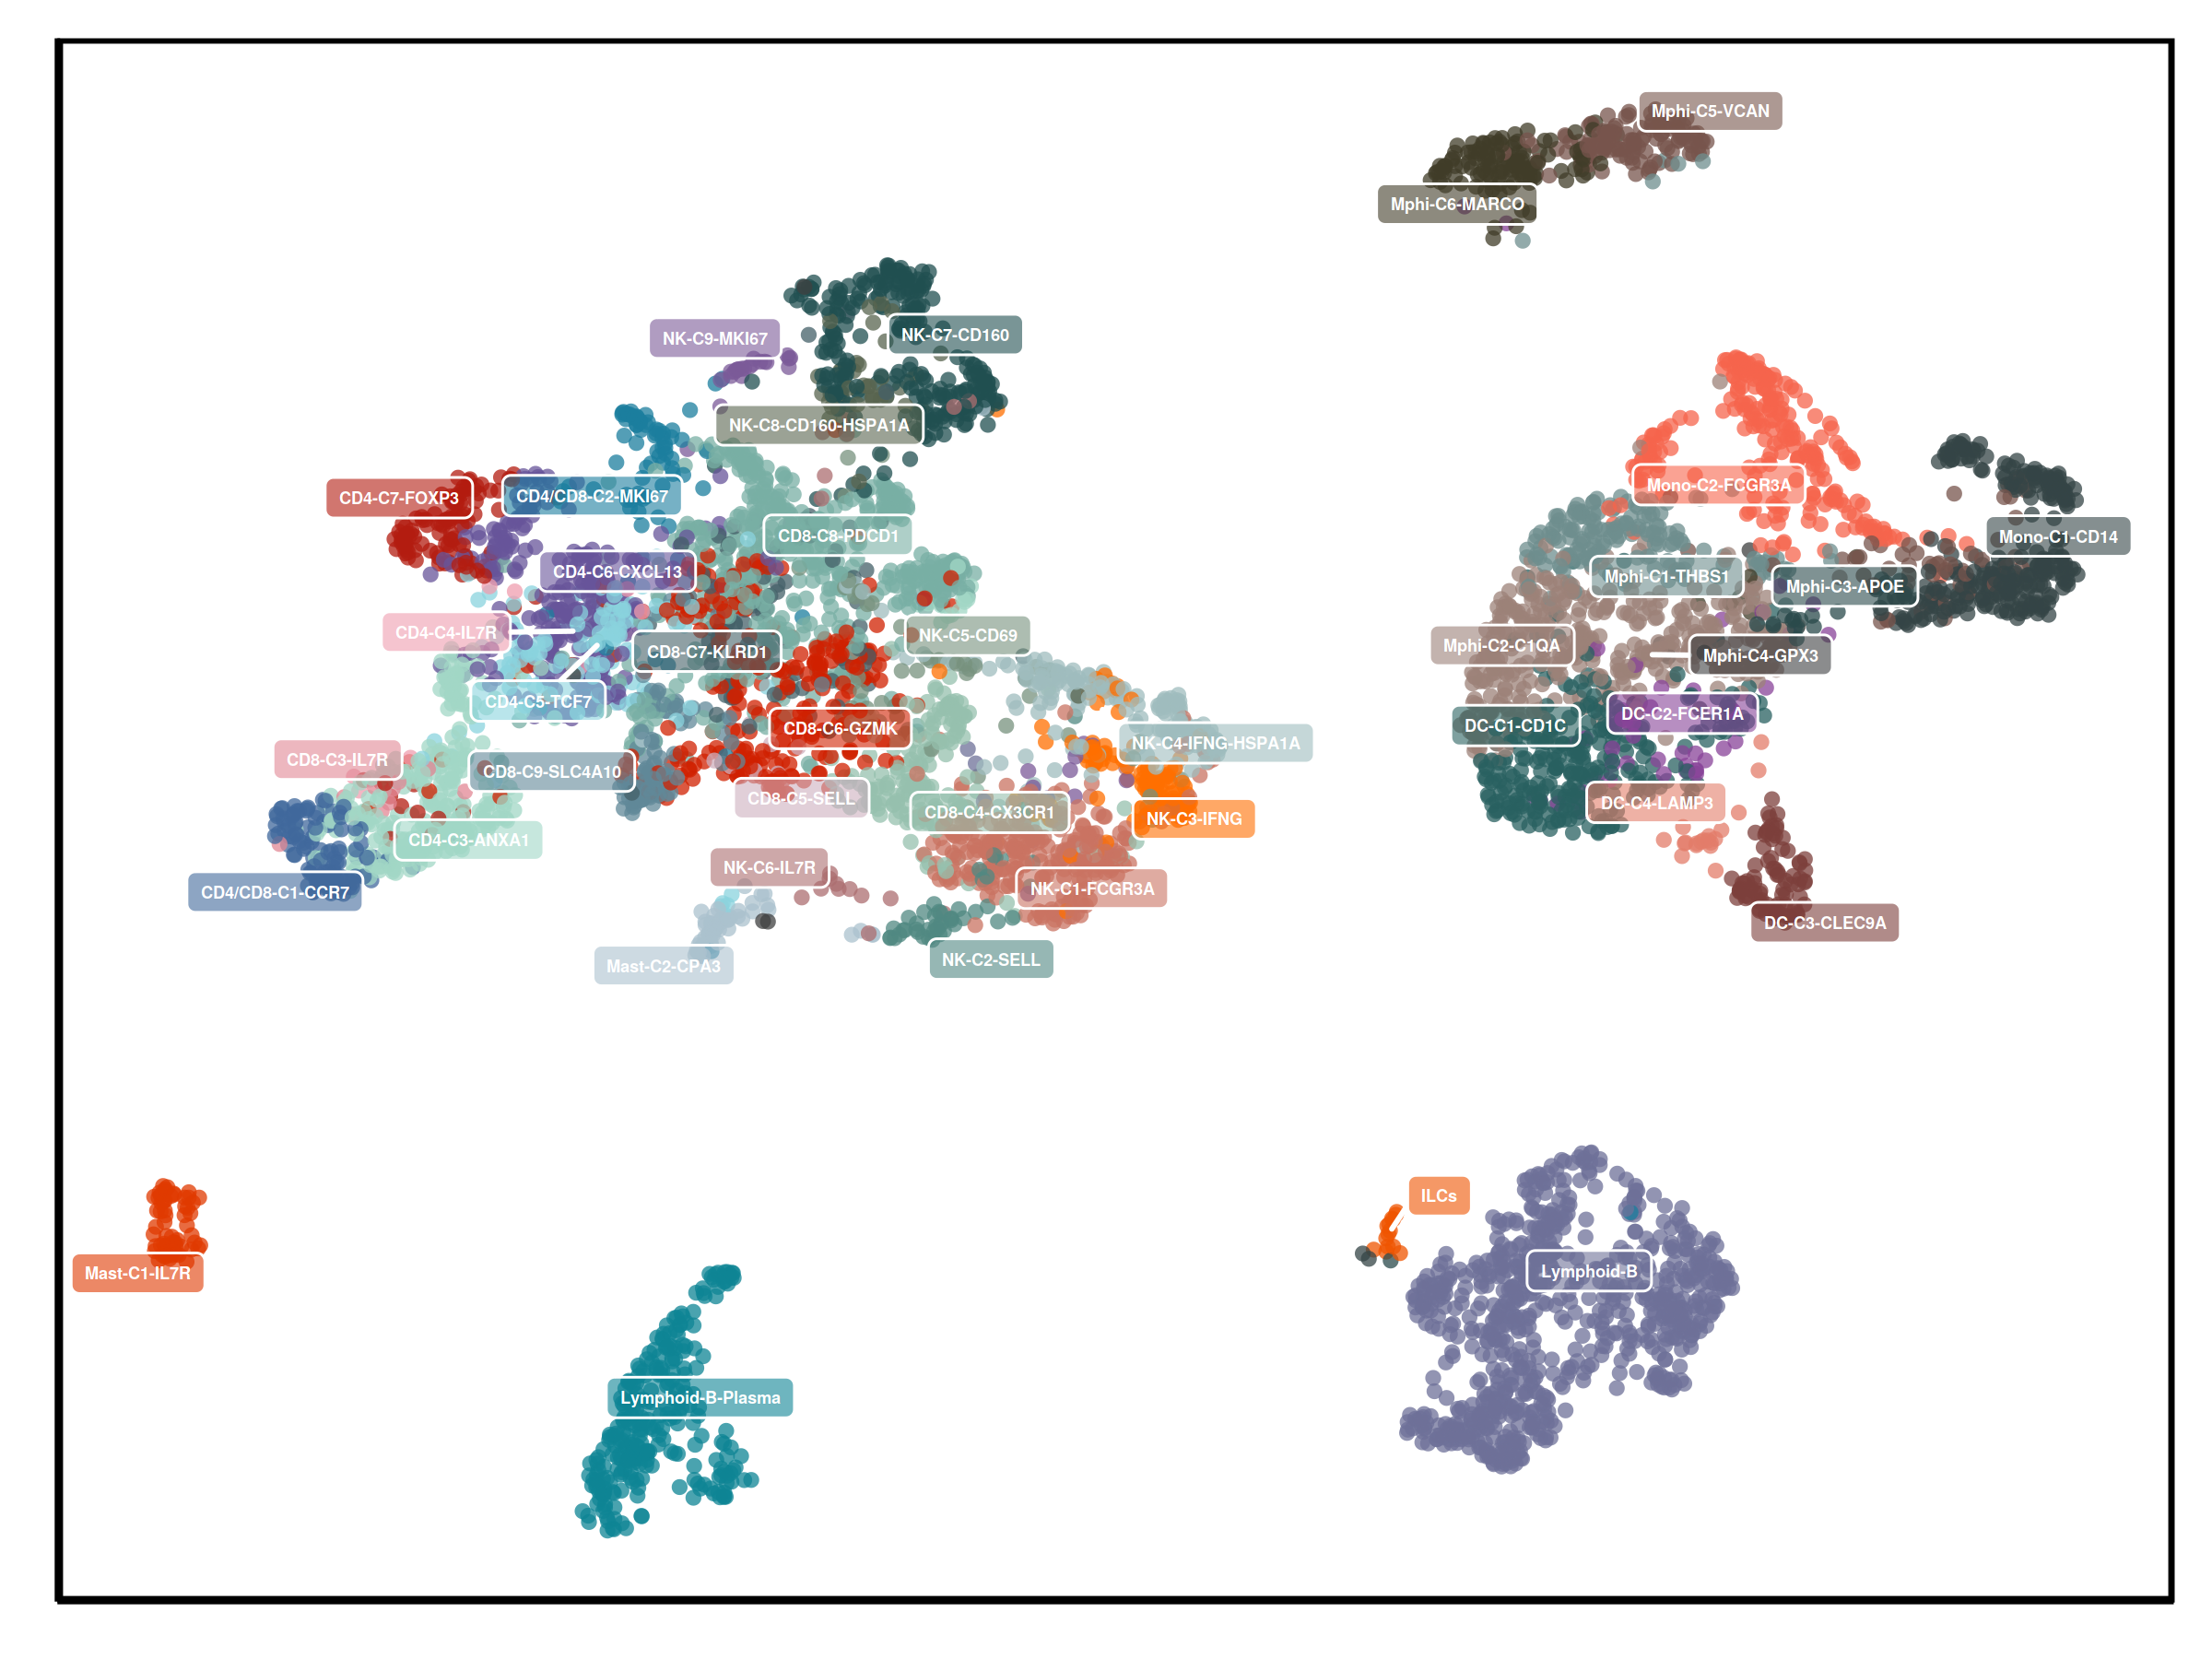

In [12]:
set.seed(104035)
pal <- ggsci::pal_futurama()(12)
cols <- colorRampPalette(pal)(length(unique(sce$celltype_CD45P)))
cols <- sample(cols)
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)
plotDF <- makePerCellDF(sce, use_dimred = T)
plotLabelDF <- plotDF %>% 
    group_by(celltype_CD45P) %>%
    summarise(UMAP.1 = median(UMAP.1),
              UMAP.2 = median(UMAP.2))
p1 <- ggplot(plotDF, aes(x=UMAP.1, y = UMAP.2) ) + 
    geom_point(aes(fill = celltype_CD45P, color = celltype_CD45P), shape = 16,alpha = 0.75, size = 1.5) +
    #geom_point(data = plotLabelDF, shape = 21, fill = 'white', alpha = .8, color = 'snow', size = 8) +
    ggrepel::geom_label_repel(data = plotLabelDF, aes(fill = celltype_CD45P, label = celltype_CD45P), color = 'white',size = 1.5,  fontface = 'bold') +
    scale_color_manual(values = cols, guide = guide_legend(title = NULL,override.aes = list(size = 4))) + 
    scale_fill_manual(values = alpha(cols, .6), guide = guide_legend(title = NULL,override.aes = list(size = 4))) + 
    
    ggpubr::theme_pubr(base_size = 20) +
    theme(legend.position = 'none', axis.ticks = element_blank(), axis.text = element_blank(), axis.title = element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=1))
p1